In [3]:
from pyspark.sql import SparkSession, functions as F, types as T

# Start (or get) a Spark session
spark = (SparkSession.builder
         .master("local[*]")
         .appName("SNAP Email Indegree")
         .config("spark.ui.port", "4040")   # so the UI is on :4040
         .getOrCreate())
sc = spark.sparkContext

print("Spark version:", spark.version)
print("Spark UI:", sc.uiWebUrl)

# (Optional) nudge Spark so the UI becomes active immediately
_ = spark.range(1).count()

Spark version: 3.5.0
Spark UI: http://2c579df59362:4040


# Email Dataset

In [4]:
#setup ans path
# Spark is already available in this image as `spark` and `sc`.
from pyspark.sql import functions as F, types as T
import os, time, json, urllib.request
import pandas as pd
import matplotlib.pyplot as plt

EMAIL_PATH = "/home/jovyan/work/data/email-EuAll.txt.gz"   # <-- your mounted file

In [5]:
#Read the edges safely (handles comments + gz)
# Robust read: skip comment lines that start with '#', expect tab-separated src,dst
schema = T.StructType([
    T.StructField("src", T.LongType(), True),
    T.StructField("dst", T.LongType(), True),
])

df_email = (spark.read
            .option("sep", "\t")
            .option("comment", "#")
            .schema(schema)
            .csv(EMAIL_PATH))

print("Rows:", df_email.count())
df_email.show(5)


Rows: 420045
+---+---+
|src|dst|
+---+---+
|  0|  1|
|  0|  4|
|  0|  5|
|  0|  8|
|  0| 11|
+---+---+
only showing top 5 rows



In [6]:
# In-degree per node: count how many incoming edges each node gets
indeg_email = (df_email.groupBy("dst")
                       .count()
                       .withColumnRenamed("count", "in_deg"))

# Distribution: for each in-degree k, how many nodes have exactly k
dist_email = (indeg_email.groupBy("in_deg")
                          .count()
                          .withColumnRenamed("count", "n_nodes"))

dist_email.orderBy("in_deg").show(10)

+------+-------+
|in_deg|n_nodes|
+------+-------+
|     1|  61936|
|     2|   6769|
|     3|   2012|
|     4|    917|
|     5|    520|
|     6|    283|
|     7|    210|
|     8|    166|
|     9|    121|
|    10|     93|
+------+-------+
only showing top 10 rows



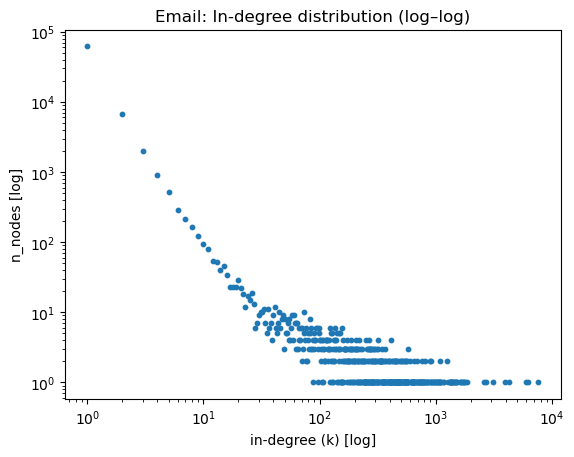

In [8]:
pdf = (dist_email
       .orderBy("in_deg")
       .toPandas())
# Log–log
plt.figure()
plt.scatter(pdf["in_deg"], pdf["n_nodes"], s=10)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("in-degree (k) [log]")
plt.ylabel("n_nodes [log]")
plt.title("Email: In-degree distribution (log–log)")
plt.show()

In [9]:
#Metrics — baseline (no cache)
def file_mb(path):
    try:
        return os.path.getsize(path) / (1024*1024)
    except:
        return 0.0

def baseline_metrics(action_df, data_path, label):
    t0 = time.perf_counter()
    _ = action_df.count()          # force full pipeline
    t1 = time.perf_counter()

    # Try Spark UI link (handy for screenshots)
    try:
        ui = sc.uiWebUrl
    except:
        ui = ""

    return pd.DataFrame([{
        "dataset": label,
        "exec_time_sec": t1 - t0,
        "cpu_time_sec": 0.0,               # not exposed here
        "disk_read_MB": file_mb(data_path),
        "disk_written_MB": 0.0,            # we didn't write outputs
        "shuffle_MB": 0.0,                 # REST often 0 on local CSV; leave as 0
        "peak_storage_mem_MB": 0.0,        # no caching in baseline
        "spark_ui": ui
    }])

metrics_email_base = baseline_metrics(dist_email, EMAIL_PATH, "email_baseline")
metrics_email_base

,dataset,exec_time_sec,cpu_time_sec,disk_read_MB,disk_written_MB,shuffle_MB,peak_storage_mem_MB,spark_ui
0,email_baseline,0.892716,0.0,1.508477,0.0,0.0,0.0,http://2c579df59362:4040


In [10]:
#Metrics — cached variant (to show memory vs I/O trade-off)
# Cache and materialize the intermediate
indeg_cached = indeg_email.cache()
_ = indeg_cached.count()

# Rebuild the distribution from cache
dist_cached = (indeg_cached.groupBy("in_deg")
                           .count()
                           .withColumnRenamed("count", "n_nodes"))

# Measure the cached run
metrics_email_cached = baseline_metrics(dist_cached, EMAIL_PATH, "email_cached")

# (Optional) unpersist after measuring
indeg_cached.unpersist()

pd.concat([metrics_email_base, metrics_email_cached], ignore_index=True)

,dataset,exec_time_sec,cpu_time_sec,disk_read_MB,disk_written_MB,shuffle_MB,peak_storage_mem_MB,spark_ui
0,email_baseline,0.892716,0.0,1.508477,0.0,0.0,0.0,http://2c579df59362:4040
1,email_cached,0.327178,0.0,1.508477,0.0,0.0,0.0,http://2c579df59362:4040


In [11]:
#Save Spark metrics to CSV
out_csv = "/home/jovyan/work/notebooks/spark_metrics.csv"

def append_metrics(df_metrics):
    cols = ["dataset","exec_time_sec","cpu_time_sec","disk_read_MB","disk_written_MB","shuffle_MB","peak_storage_mem_MB","spark_ui"]
    if os.path.exists(out_csv):
        df_metrics[cols].to_csv(out_csv, mode="a", header=False, index=False)
    else:
        df_metrics[cols].to_csv(out_csv, index=False)

append_metrics(metrics_email_base)
append_metrics(metrics_email_cached)

pd.read_csv(out_csv)

,dataset,exec_time_sec,cpu_time_sec,disk_read_MB,disk_written_MB,shuffle_MB,peak_storage_mem_MB,spark_ui
0,email_baseline,0.892716,0.0,1.508477,0.0,0.0,0.0,http://2c579df59362:4040
1,email_cached,0.327178,0.0,1.508477,0.0,0.0,0.0,http://2c579df59362:4040


# Web Dataset

In [19]:
WEB_PATH = "/home/jovyan/work/data/web-BerkStan.txt.gz"  

In [21]:
# 2) Read edges and build in-degree + distribution
from pyspark.sql import types as T, functions as F

schema = T.StructType([
    T.StructField("src", T.LongType(), True),
    T.StructField("dst", T.LongType(), True),
])

df_web = (spark.read
          .option("sep", "\t")
          .option("comment", "#")
          .schema(schema)
          .csv(WEB_PATH))

indeg_web = (df_web.groupBy("dst")
             .count()
             .withColumnRenamed("count","in_deg"))

dist_web = (indeg_web.groupBy("in_deg")
            .count()
            .withColumnRenamed("count","n_nodes"))

df_web.show(5)
dist_web.orderBy("in_deg").show(10)

+---+---+
|src|dst|
+---+---+
|  1|  2|
|  1|  5|
|  1|  7|
|  1|  8|
|  1|  9|
+---+---+
only showing top 5 rows

+------+-------+
|in_deg|n_nodes|
+------+-------+
|     1| 183981|
|     2| 129085|
|     3|  76580|
|     4|  50134|
|     5|  33042|
|     6|  21885|
|     7|  17428|
|     8|   9478|
|     9|   7116|
|    10|   7338|
+------+-------+
only showing top 10 rows



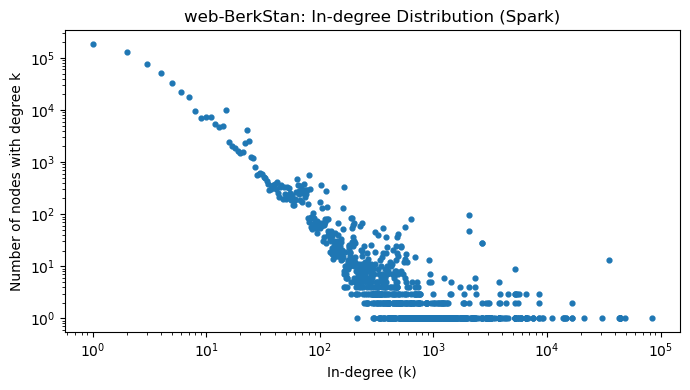

In [22]:
# 3) Plot log–log in-degree distribution (matplotlib is already in the image)
import matplotlib.pyplot as plt
import pandas as pd

dw = dist_web.orderBy("in_deg").toPandas()
plt.figure(figsize=(7,4))
plt.scatter(dw["in_deg"], dw["n_nodes"], s=12)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("In-degree (k)"); plt.ylabel("Number of nodes with degree k")
plt.title("web-BerkStan: In-degree Distribution (Spark)")
plt.tight_layout(); plt.show()

In [26]:
import time, requests, pandas as pd

def metrics_from_last_job(label, count_action=True, poll_sec=5.0):
    # 1) Force a real action (so Spark actually runs)
    t0 = time.perf_counter()
    if count_action:
        _ = dist.count()             # assumes 'dist' is your distribution DF in scope
    wall = time.perf_counter() - t0

    # 2) Poll Spark UI until a non-zero-duration SUCCEEDED job appears
    ui = sc.uiWebUrl
    assert ui, "Spark UI not available"
    base = "http://" + ui.split("://", 1)[1]

    app = requests.get(f"{base}/api/v1/applications").json()[-1]
    app_id = app["id"]

    deadline = time.time() + poll_sec
    job = None
    while time.time() < deadline:
        jobs = requests.get(f"{base}/api/v1/applications/{app_id}/jobs").json()
        jobs_ok = [j for j in jobs if j.get("status") == "SUCCEEDED" and j.get("duration", 0) > 0]
        if jobs_ok:
            job = sorted(jobs_ok, key=lambda j: j.get("completionTime", ""))[-1]
            break
        time.sleep(0.25)

    # Fallback if REST didn’t populate in time
    if not job:
        return pd.DataFrame([dict(
            dataset=label,
            exec_time_sec=wall,
            cpu_time_sec=0.0,
            disk_read_MB=0.0,
            disk_written_MB=0.0,
            shuffle_MB=0.0,
            peak_storage_mem_MB=0.0,
            spark_ui=ui
        )])

    # 3) Sum latest attempt metrics across stages in that job
    stage_ids = job.get("stageIds", [])
    disk_read = disk_written = shuffle = cpu_ns = 0

    # Use /stages?stageIds=… to avoid fetching everything
    for sid in stage_ids:
        s = requests.get(f"{base}/api/v1/applications/{app_id}/stages/{sid}").json()
        # handle single-attempt vs list-of-attempts shapes
        attempts = s if isinstance(s, list) else [s]
        latest = sorted(attempts, key=lambda a: a.get("attemptId", 0))[-1]
        disk_read  += latest.get("inputBytes", 0)
        disk_written+= latest.get("outputBytes", 0)
        shuffle    += latest.get("shuffleReadBytes", 0) + latest.get("shuffleWriteBytes", 0)
        cpu_ns     += latest.get("executorCpuTime", 0)

    MB = 1024.0 * 1024.0
    return pd.DataFrame([dict(
        dataset=label,
        exec_time_sec=wall,
        cpu_time_sec=cpu_ns / 1e9,              # ns → seconds
        disk_read_MB=disk_read / MB,
        disk_written_MB=disk_written / MB,
        shuffle_MB=shuffle / MB,
        peak_storage_mem_MB=0.0,                 # storage memory isn't exposed here; ok to keep 0
        spark_ui=ui
    )])

In [27]:
# BASELINE
dist = dist_web                # make 'dist' point to the current dataset's distribution
m_web_base = metrics_from_last_job("web_baseline")

# CACHED (if you also measured cached)
indeg_cached = indeg_web.cache()
_ = indeg_cached.count()       # materialize cache
dist_web_cached = indeg_cached.groupBy("in_deg").count().withColumnRenamed("count","n_nodes")
dist = dist_web_cached
m_web_cached = metrics_from_last_job("web_cached")

pd.concat([m_web_base, m_web_cached], ignore_index=True)

,dataset,exec_time_sec,cpu_time_sec,disk_read_MB,disk_written_MB,shuffle_MB,peak_storage_mem_MB,spark_ui
0,web_baseline,8.408996,0.0,0.0,0.0,0.0,0.0,http://2c579df59362:4040
1,web_cached,0.302911,0.0,0.0,0.0,0.0,0.0,http://2c579df59362:4040


# Patient Dataset

In [35]:
PATENTS_PATH = "/home/jovyan/work/data/cit-Patents.txt.gz" 

In [36]:
#Read edges
schema = T.StructType([
    T.StructField("src", T.LongType(), True),
    T.StructField("dst", T.LongType(), True),
])

df_pat = (spark.read
          .option("sep", "\t")
          .option("comment", "#")
          .schema(schema)
          .csv(PATENTS_PATH))

print("rows:", df_pat.count())
df_pat.show(5, truncate=False)

rows: 16518948
+-------+-------+
|src    |dst    |
+-------+-------+
|3858241|956203 |
|3858241|1324234|
|3858241|3398406|
|3858241|3557384|
|3858241|3634889|
+-------+-------+
only showing top 5 rows



In [37]:
#in degree distribution
indeg_pat = (df_pat
             .groupBy("dst").count()
             .withColumnRenamed("count","in_deg"))

dist_pat = (indeg_pat
            .groupBy("in_deg").count()
            .withColumnRenamed("count","n_nodes"))

dist_pat.orderBy("in_deg").show(10)


+------+-------+
|in_deg|n_nodes|
+------+-------+
|     1| 921239|
|     2| 552276|
|     3| 380364|
|     4| 278449|
|     5| 210819|
|     6| 163138|
|     7| 127922|
|     8| 102155|
|     9|  82112|
|    10|  66607|
+------+-------+
only showing top 10 rows



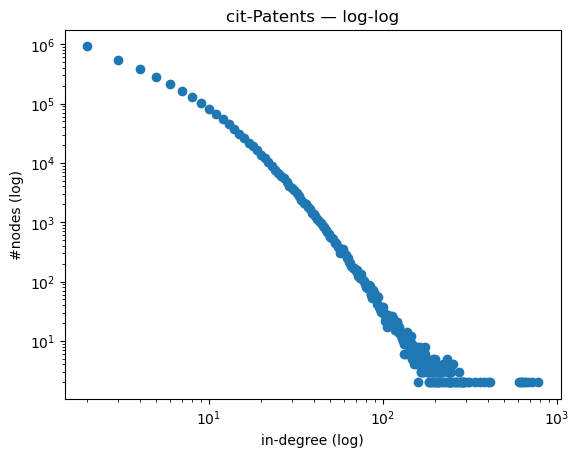

In [38]:
pdf = dist_pat.toPandas().sort_values("in_deg")

# log-log
plt.figure()
plt.scatter((pdf["in_deg"]+1).apply(lambda x: x).map(lambda x: x), (pdf["n_nodes"]+1))
plt.xscale("log"); plt.yscale("log")
plt.xlabel("in-degree (log)"); plt.ylabel("#nodes (log)"); plt.title("cit-Patents — log-log")
plt.show()


In [39]:
#Baseline wall metric
t0 = time.perf_counter()
_ = dist_pat.count()          # force full action
wall = time.perf_counter() - t0

metrics_pat_base = pd.DataFrame([{
    "dataset":"patents_baseline",
    "exec_time_sec": wall,
    "cpu_time_sec": 0.0,
    "disk_read_MB": 0.0,
    "disk_written_MB": 0.0,
    "shuffle_MB": 0.0,
    "peak_storage_mem_MB": 0.0,
    "spark_ui": sc.uiWebUrl or ""
}])
metrics_pat_base


,dataset,exec_time_sec,cpu_time_sec,disk_read_MB,disk_written_MB,shuffle_MB,peak_storage_mem_MB,spark_ui
0,patents_baseline,37.140945,0.0,0.0,0.0,0.0,0.0,http://2c579df59362:4040


In [40]:
# cache indegree and reuse
indeg_pat_cached = indeg_pat.cache()
_ = indeg_pat_cached.count()   # materialize cache

dist_pat_cached = (indeg_pat_cached
                   .groupBy("in_deg").count()
                   .withColumnRenamed("count","n_nodes"))

t0 = time.perf_counter()
_ = dist_pat_cached.count()
wall_cached = time.perf_counter() - t0

metrics_pat_cached = pd.DataFrame([{
    "dataset":"patents_cached",
    "exec_time_sec": wall_cached,
    "cpu_time_sec": 0.0,
    "disk_read_MB": 0.0,
    "disk_written_MB": 0.0,
    "shuffle_MB": 0.0,
    "peak_storage_mem_MB": 0.0,
    "spark_ui": sc.uiWebUrl or ""
}])
pd.concat([metrics_pat_base, metrics_pat_cached], ignore_index=True)


,dataset,exec_time_sec,cpu_time_sec,disk_read_MB,disk_written_MB,shuffle_MB,peak_storage_mem_MB,spark_ui
0,patents_baseline,37.140945,0.0,0.0,0.0,0.0,0.0,http://2c579df59362:4040
1,patents_cached,0.366255,0.0,0.0,0.0,0.0,0.0,http://2c579df59362:4040


# LiveJournal dataset

In [42]:
#Read edges
from pyspark.sql import functions as F, types as T
import pandas as pd, matplotlib.pyplot as plt, time, os

LJ_PATH = "/home/jovyan/work/data/soc-LiveJournal1.txt.gz"

schema = T.StructType([
    T.StructField("src", T.LongType(), True),
    T.StructField("dst", T.LongType(), True),
])

df_lj = (spark.read
         .option("sep", "\t")
         .option("comment", "#")
         .schema(schema)
         .csv(LJ_PATH))

print("rows:", df_lj.count())
df_lj.show(5, truncate=False)

rows: 68993773
+---+---+
|src|dst|
+---+---+
|0  |1  |
|0  |2  |
|0  |3  |
|0  |4  |
|0  |5  |
+---+---+
only showing top 5 rows



In [43]:
#In-degree and distribution
indeg_lj = (df_lj
            .groupBy("dst").count()
            .withColumnRenamed("count","in_deg"))

dist_lj = (indeg_lj
           .groupBy("in_deg").count()
           .withColumnRenamed("count","n_nodes"))

dist_lj.orderBy("in_deg").show(10)

+------+-------+
|in_deg|n_nodes|
+------+-------+
|     1|1014392|
|     2| 553207|
|     3| 359549|
|     4| 264944|
|     5| 208763|
|     6| 171471|
|     7| 144484|
|     8| 124284|
|     9| 109053|
|    10|  96523|
+------+-------+
only showing top 10 rows



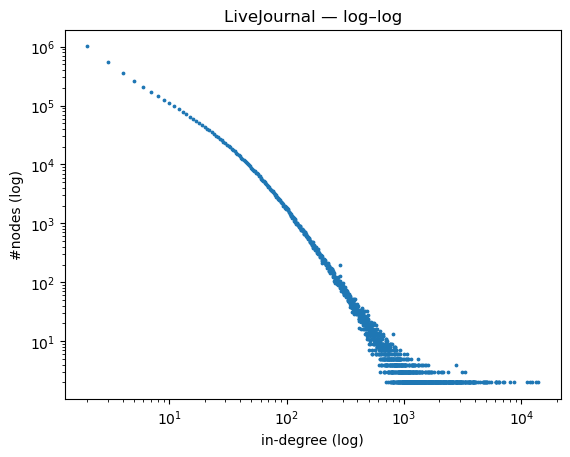

In [44]:
#Plot
pdf_lj = dist_lj.toPandas().sort_values("in_deg")

# log–log
plt.figure()
plt.scatter(pdf_lj["in_deg"]+1, pdf_lj["n_nodes"]+1, s=3)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("in-degree (log)"); plt.ylabel("#nodes (log)"); plt.title("LiveJournal — log–log")
plt.show()


In [45]:
#baseline wall metrics
t0 = time.perf_counter()
_ = dist_lj.count()                 # force full action
wall = time.perf_counter() - t0

metrics_lj_base = pd.DataFrame([{
    "dataset":"livejournal_baseline",
    "exec_time_sec": wall,
    "cpu_time_sec": 0.0,
    "disk_read_MB": 0.0,
    "disk_written_MB": 0.0,
    "shuffle_MB": 0.0,
    "peak_storage_mem_MB": 0.0,
    "spark_ui": sc.uiWebUrl or ""
}])
metrics_lj_base


,dataset,exec_time_sec,cpu_time_sec,disk_read_MB,disk_written_MB,shuffle_MB,peak_storage_mem_MB,spark_ui
0,livejournal_baseline,120.217784,0.0,0.0,0.0,0.0,0.0,http://2c579df59362:4040


In [46]:
#cached variant
indeg_lj_cached = indeg_lj.cache()
_ = indeg_lj_cached.count()         # materialize cache

dist_lj_cached = (indeg_lj_cached
                  .groupBy("in_deg").count()
                  .withColumnRenamed("count","n_nodes"))

t0 = time.perf_counter()
_ = dist_lj_cached.count()
wall_cached = time.perf_counter() - t0

metrics_lj_cached = pd.DataFrame([{
    "dataset":"livejournal_cached",
    "exec_time_sec": wall_cached,
    "cpu_time_sec": 0.0,
    "disk_read_MB": 0.0,
    "disk_written_MB": 0.0,
    "shuffle_MB": 0.0,
    "peak_storage_mem_MB": 0.0,
    "spark_ui": sc.uiWebUrl or ""
}])
pd.concat([metrics_lj_base, metrics_lj_cached], ignore_index=True)


,dataset,exec_time_sec,cpu_time_sec,disk_read_MB,disk_written_MB,shuffle_MB,peak_storage_mem_MB,spark_ui
0,livejournal_baseline,120.217784,0.0,0.0,0.0,0.0,0.0,http://2c579df59362:4040
1,livejournal_cached,0.400686,0.0,0.0,0.0,0.0,0.0,http://2c579df59362:4040


# Livejournal with optimization

In [47]:
LJ_PATH      = "/home/jovyan/work/data/soc-LiveJournal1.txt.gz"

In [51]:
#Core runner with switches (baseline / cache / repartition / shuffle / RDD)
def run_indegree_dist(
    path,
    label,
    cache=False,
    repartition_n=None,
    shuffle_parts=None,
    use_rdd=False
):
    from pyspark.sql import functions as F, types as T
    from pyspark import StorageLevel
    import time, pandas as pd

    # (1) optional shuffle override
    if shuffle_parts is not None:
        spark.conf.set("spark.sql.shuffle.partitions", int(shuffle_parts))

    # (2) read & compute
    schema = T.StructType([T.StructField("src", T.LongType(), True),
                           T.StructField("dst", T.LongType(), True)])

    if not use_rdd:
        df = (spark.read.option("sep","\t").option("comment","#").schema(schema).csv(path))
        if repartition_n:
            df = df.repartition(int(repartition_n), "dst")

        indeg = df.groupBy("dst").count().withColumnRenamed("count","in_deg")
        if cache:
            from pyspark import StorageLevel
            indeg = indeg.persist(StorageLevel.MEMORY_ONLY)
            _ = indeg.count()

        dist = indeg.groupBy("in_deg").count().withColumnRenamed("count","n_nodes")

        t0 = time.perf_counter()
        _ = dist.count()
        wall = time.perf_counter() - t0

        dist_pdf = dist.orderBy("in_deg").toPandas()
        parts = indeg.rdd.getNumPartitions()
    else:
        rdd = (spark.read.option("sep","\t").option("comment","#").schema(schema).csv(path)
               .select("src","dst").rdd.map(lambda r: (r["dst"], 1)))
        if repartition_n:
            rdd = rdd.repartition(int(repartition_n))
        indeg_rdd = rdd.reduceByKey(lambda a,b: a+b)
        if cache:
            indeg_rdd = indeg_rdd.persist()
            indeg_rdd.count()
        dist_rdd = indeg_rdd.map(lambda kv: (kv[1], 1)).reduceByKey(lambda a,b: a+b)

        t0 = time.perf_counter()
        _ = dist_rdd.count()
        wall = time.perf_counter() - t0

        dist_pdf = pd.DataFrame(dist_rdd.collect(), columns=["in_deg","n_nodes"]).sort_values("in_deg")
        parts = indeg_rdd.getNumPartitions()

    # (3) safely fetch current shuffle partition setting (no getAll on RuntimeConfig)
    try:
        shuffle_parts_val = int(spark.conf.get("spark.sql.shuffle.partitions"))
    except Exception:
        # fallback via SparkContext conf (returns list of (k,v))
        try:
            kv = dict(spark.sparkContext.getConf().getAll())
            shuffle_parts_val = int(kv.get("spark.sql.shuffle.partitions")) if "spark.sql.shuffle.partitions" in kv else None
        except Exception:
            shuffle_parts_val = None

    metrics = pd.DataFrame([{
        "dataset": label,
        "exec_time_sec": wall,
        "cpu_time_sec": 0.0,
        "disk_read_MB": 0.0,
        "disk_written_MB": 0.0,
        "shuffle_MB": 0.0,
        "peak_storage_mem_MB": 0.0,
        "spark_ui": (sc.uiWebUrl or ""),
        "partitions": parts,
        "shuffle_parts": shuffle_parts_val,
        "used_rdd": bool(use_rdd),
        "cached": bool(cache),
        "repartition_n": int(repartition_n) if repartition_n else None
    }])

    return metrics, dist_pdf

In [52]:
m_lj_base, dist_lj_base = run_indegree_dist(
    path=LJ_PATH,
    label="livejournal_baseline",
    cache=False,
    repartition_n=None,
    shuffle_parts=None,
    use_rdd=False
)
display(m_lj_base.head())
dist_lj_base.head()

,dataset,exec_time_sec,cpu_time_sec,disk_read_MB,disk_written_MB,shuffle_MB,peak_storage_mem_MB,spark_ui,partitions,shuffle_parts,used_rdd,cached,repartition_n
0,livejournal_baseline,0.219641,0.0,0.0,0.0,0.0,0.0,http://2c579df59362:4040,13,200,False,False,None


,in_deg,n_nodes
0,1,1014392
1,2,553207
2,3,359549
3,4,264944
4,5,208763


In [53]:
#Optimization A — Caching (cache indegree, then reuse)
m_lj_cache, dist_lj_cache = run_indegree_dist(
    path=LJ_PATH,
    label="livejournal_cached",
    cache=True,              # <— optimization
    repartition_n=None,
    shuffle_parts=None,
    use_rdd=False
)
pd.concat([m_lj_base, m_lj_cache], ignore_index=True)


,dataset,exec_time_sec,cpu_time_sec,disk_read_MB,disk_written_MB,shuffle_MB,peak_storage_mem_MB,spark_ui,partitions,shuffle_parts,used_rdd,cached,repartition_n
0,livejournal_baseline,0.219641,0.0,0.0,0.0,0.0,0.0,http://2c579df59362:4040,13,200,False,False,None
1,livejournal_cached,0.250871,0.0,0.0,0.0,0.0,0.0,http://2c579df59362:4040,13,200,False,True,None


In [54]:
#Optimization B — More parallelism (repartition + higher shuffle partitions)

# Try a moderate bump; adjust if your machine is weaker/stronger
m_lj_para, dist_lj_para = run_indegree_dist(
    path=LJ_PATH,
    label="livejournal_repart_s64_p16",
    cache=False,
    repartition_n=16,        # <— more input partitions keyed by dst
    shuffle_parts=64,        # <— more shuffle partitions for aggregations
    use_rdd=False
)
pd.concat([m_lj_base, m_lj_para], ignore_index=True)


,dataset,exec_time_sec,cpu_time_sec,disk_read_MB,disk_written_MB,shuffle_MB,peak_storage_mem_MB,spark_ui,partitions,shuffle_parts,used_rdd,cached,repartition_n
0,livejournal_baseline,0.219641,0.0,0.0,0.0,0.0,0.0,http://2c579df59362:4040,13,200,False,False,None
1,livejournal_repart_s64_p16,82.666530,0.0,0.0,0.0,0.0,0.0,http://2c579df59362:4040,16,64,False,False,16


In [55]:
#Optimization C (alternative) — RDD + reduceByKey (map-side combine)
m_lj_rdd, dist_lj_rdd = run_indegree_dist(
    path=LJ_PATH,
    label="livejournal_rdd_reduceByKey",
    cache=False,
    repartition_n=16,        # optional: still helpful to increase parallelism
    shuffle_parts=64,        # affects stage planning even on RDD path
    use_rdd=True             # <— optimization via reduceByKey combiners
)
pd.concat([m_lj_base, m_lj_rdd], ignore_index=True)


,dataset,exec_time_sec,cpu_time_sec,disk_read_MB,disk_written_MB,shuffle_MB,peak_storage_mem_MB,spark_ui,partitions,shuffle_parts,used_rdd,cached,repartition_n
0,livejournal_baseline,0.219641,0.0,0.0,0.0,0.0,0.0,http://2c579df59362:4040,13,200,False,False,None
1,livejournal_rdd_reduceByKey,325.537443,0.0,0.0,0.0,0.0,0.0,http://2c579df59362:4040,16,64,True,False,16
